# Part A Algorithmic Trading System using Machine Learning


In [2]:
# Imports 
import warnings
warnings.filterwarnings("ignore")

import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from tensorflow import keras 
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Nadam
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error


## Data Processing

### Importing the data

In [3]:
# Importing the data
data = pd.read_csv("data_training_Project_ML_Finance.csv", index_col="Day")
# data.head()
# data.describe()

In [5]:
# Get the list of stock columns
stock_columns = [col for col in data.columns if col not in ['Weekday', 'Macro Environment']]#['Day', 'Weekday', 'Macro Environment']]

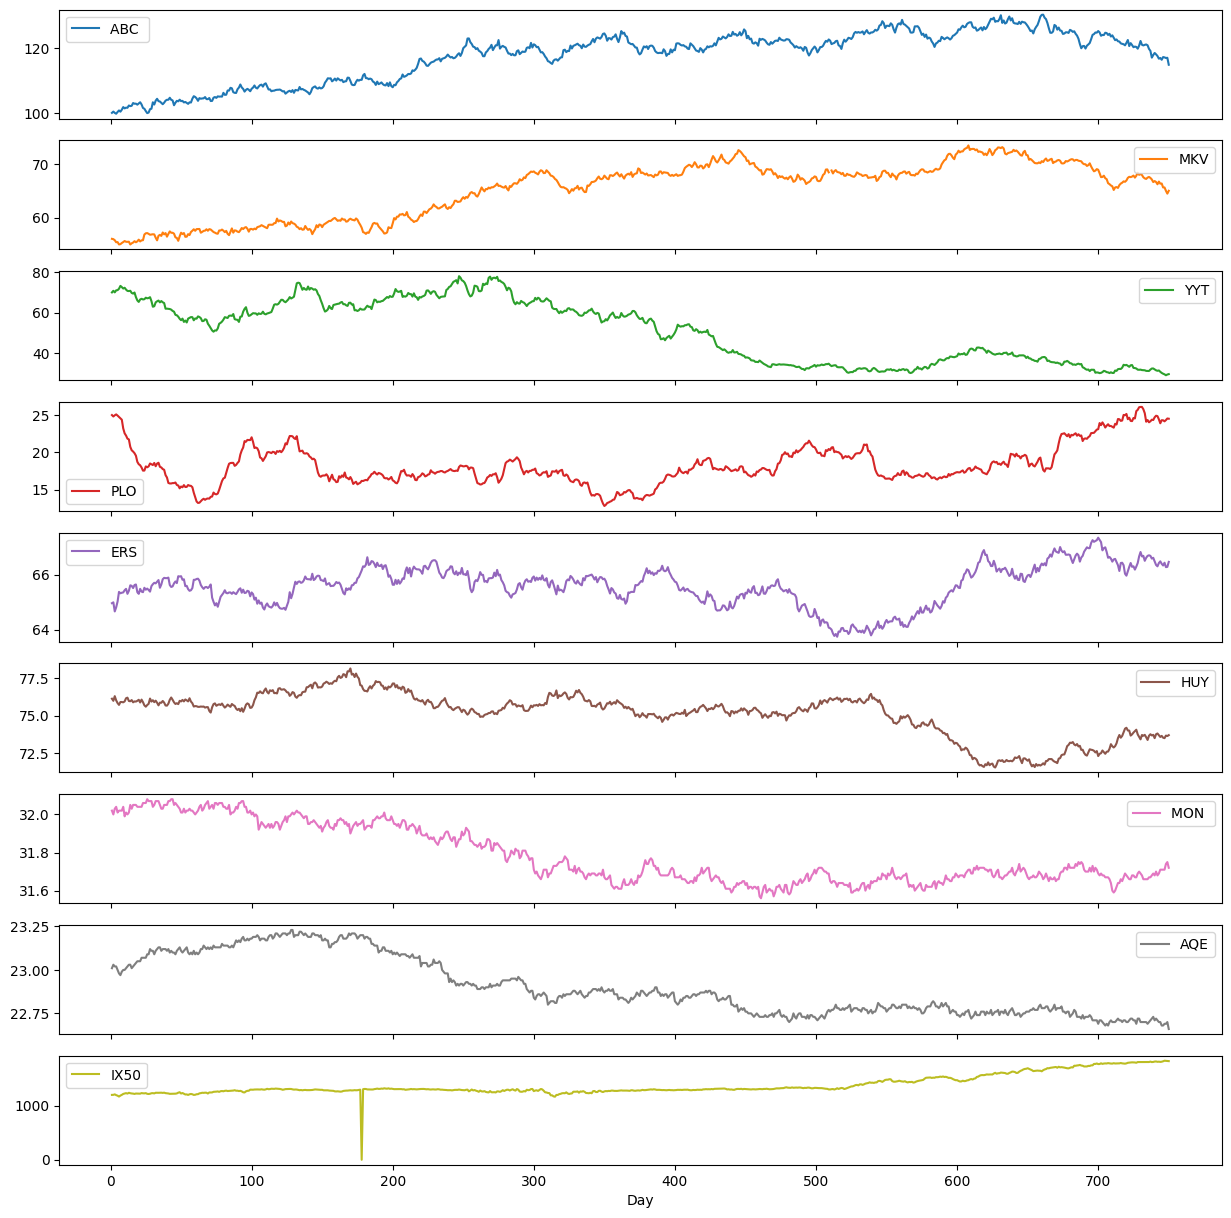

In [6]:
plot_features = data[stock_columns]
_ = plot_features.plot(subplots=True,figsize=(15,15))

### Outlier handling

#### Handling numberical outliers 

In [7]:
# Copying the imported data 
data_cleaning_df = data.copy() 

In [8]:
# Function for soft imputation using linear interpolation
def soft_impute_outliers(data, col):
    # Identify outliers and replace them with NaN for interpolation
    outlier_indices = data[(data[col] <= 0)].index# | (data[col] > .5)].index
    data.loc[outlier_indices, col] = None
    
    # Interpolate the NaN values
    data[col].interpolate(method='linear' ,inplace=True)

# Apply soft imputation on the stock columns to handle outliers
for col in stock_columns:
    soft_impute_outliers(data_cleaning_df, col)

# plot_features = data_cleaning_df[stock_columns]
# _ = plot_features.plot(subplots=True,figsize=(15,15))

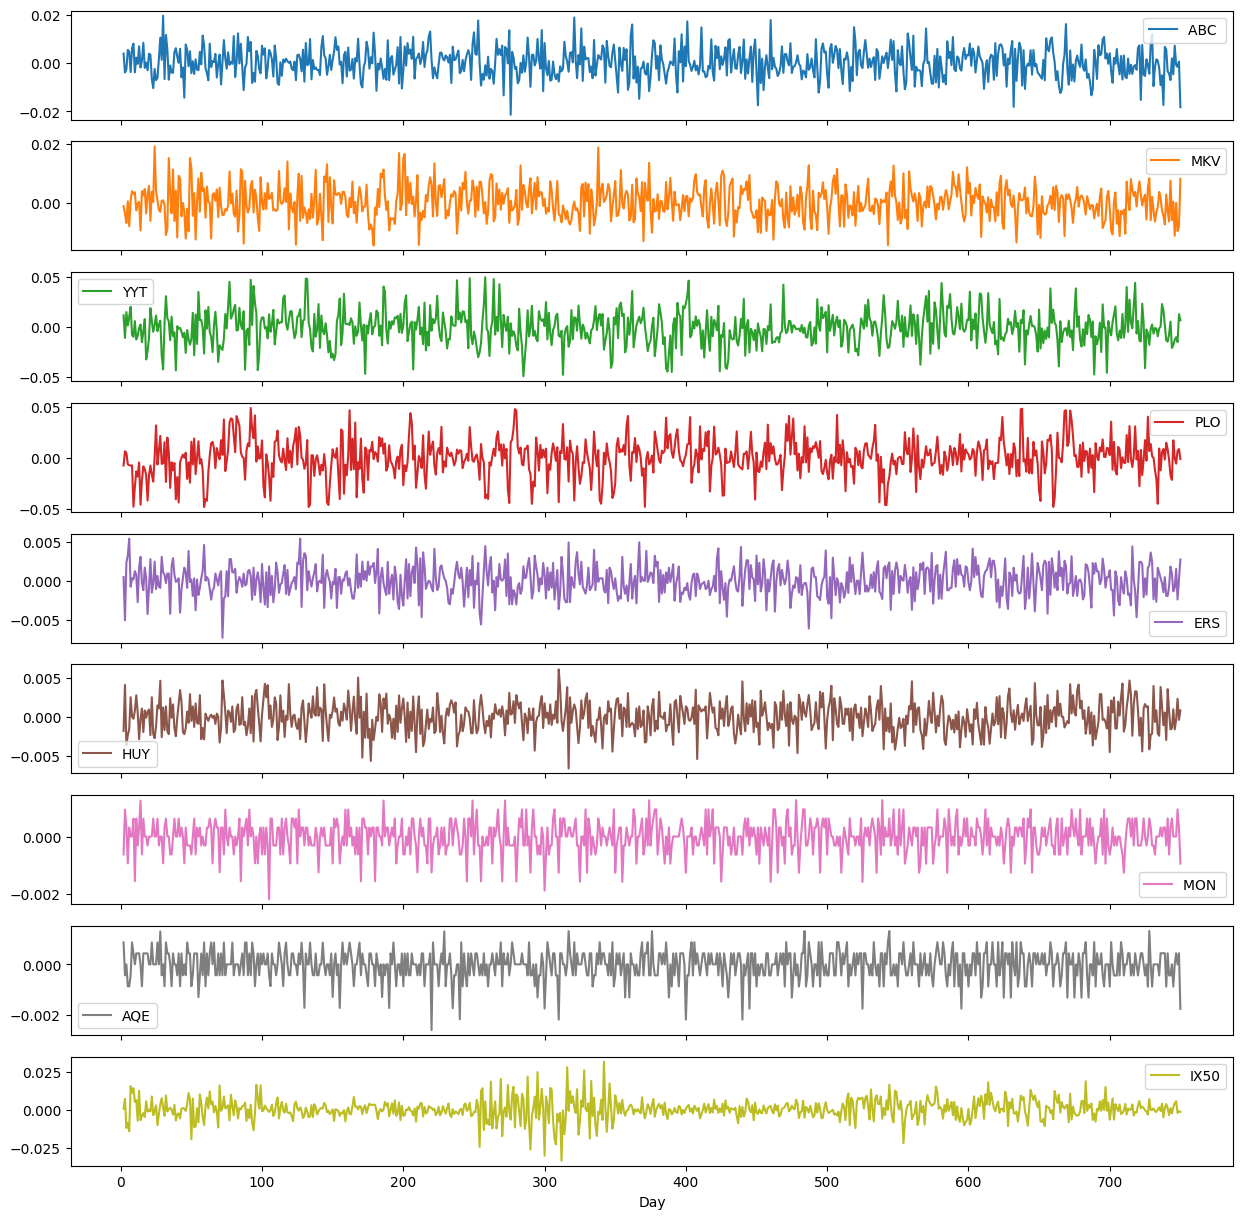

In [9]:
# Transforming the prices into return 
data_cleaning_df[stock_columns] = data_cleaning_df[stock_columns].copy().pct_change()

# Plotting the returns 
plot_features = data_cleaning_df[stock_columns]
_ = plot_features.plot(subplots=True,figsize=(15,15))

#### Handling errors in categorical values 

In [10]:
# Fixing potential spelling or capitalization mistakes in Categorical data 
categorical_data = data_cleaning_df.select_dtypes(exclude=['float64', 'int64']).columns.tolist()
for category in categorical_data:
    data_cleaning_df[category] = data_cleaning_df[category].str.lower()

## Identified that the "?" is supposed to be a Thursday 
# data_cleaning_df[data_cleaning_df["Weekday"]=="?"]
# data_cleaning_df.iloc[552:555]

# Seems to be an issue with Thursdays
correct_mapping = {
    'monday': 'Monday',
    'tuesday': 'Tuesday',
    'wednesday': 'Wednesday',
    'thurday': 'Thursday', 
    '?'  : 'Thursday',
    'thursday': 'Thursday',
    'friday': 'Friday',
}

# Replace the misspelled days using the mapping
data_cleaning_df['Weekday'] = data_cleaning_df['Weekday'].replace(correct_mapping)
# data_cleaning_df["Weekday"].unique()

# # Checkin for errors in the Macro Environment column 
# data["Macro Environment"].unique()
# No errors were identified 

## Feature Engineering
Feature engineering is crucial, especially for time series financial data, as it helps capture temporal patterns and other market dynamics that might not be apparent in the raw data.

In [11]:
data_featured = data_cleaning_df.copy()

In [12]:
# Creating dummies for categorical data 
data_featured = pd.get_dummies(data_featured, columns=["Weekday", "Macro Environment"])
# data_featured 

In [13]:
# Lagged Features
# To capture the "memory" or the past values of the series, which can be critical for predicting future values 
# Define a function to create lagged features
def create_lagged_features(data, col, lag):
    for i in range(1, lag + 1):
        data[f"{col}_lag_{i}"] = data[col].shift(i)
    return data

# Create lagged features for each stock column
lag = 60
for col in stock_columns:
    data_featured = create_lagged_features(data_featured, col, lag)

# Display the first few rows with lagged features
# data_featured.head()

In [14]:
# Technical indicators can help capture certain patterns or trends in the data. Common indicators include:
# Moving Averages (Simple)
# Relative Strength Index (RSI)

# Function to compute moving average
def compute_moving_average(data, col, window=5):
    return data[col].rolling(window=window).mean()

# Function to compute RSI
def compute_rsi(data, col, window=14):
    delta = data[col].diff(1)
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

# Applying MA and RSI 
for stock in stock_columns: 
    # Compute Moving Average (MA) and RSI for the chosen stock
    # data_featured[f'{stock}_MA_120'] = compute_moving_average(data_featured, stock, window=120)
    # data_featured[f'{stock}_MA_90'] = compute_moving_average(data_featured, stock, window=90)
    data_featured[f'{stock}_MA_60'] = compute_moving_average(data_featured, stock, window=60)
    data_featured[f'{stock}_MA_30'] = compute_moving_average(data_featured, stock, window=30)
    data_featured[f'{stock}_MA_14'] = compute_moving_average(data_featured, stock, window=14)
    data_featured[f'{stock}_MA_7'] = compute_moving_average(data_featured, stock, window=7)  
    
    # data_featured[f'{stock}_RSI_120'] = compute_rsi(data_featured, stock, window=120)
    # data_featured[f'{stock}_RSI_90'] = compute_rsi(data_featured, stock, window=90)
    data_featured[f'{stock}_RSI_60'] = compute_rsi(data_featured, stock, window=60)
    data_featured[f'{stock}_RSI_30'] = compute_rsi(data_featured, stock, window=30)
    data_featured[f'{stock}_RSI_14'] = compute_rsi(data_featured, stock, window=14)      
    data_featured[f'{stock}_RSI_7'] = compute_rsi(data_featured, stock, window=7)

# Display the first few rows with the new technical indicators
# data[[stock, f'{stock}_MA_5', f'{stock}_RSI_14']].head(20)



In [15]:
# # Statistical Features:
# # Correlations: Capture how different stocks move in relation to each other.
# # Volatility: Measure of price variation over time, often calculated using rolling standard deviation.

# correlation_matrix = data[stock_columns].corr()
# correlation_matrix

# Define a function to compute volatility using rolling standard deviation
def compute_volatility(data, col, window=14):
    return data[col].rolling(window=window).std()

# Compute volatility for each stock column
for stock in stock_columns:
    # data_featured[f'{stock}_volatility_120'] = compute_volatility(data_featured, stock, window=120)
    # data_featured[f'{stock}_volatility_90'] =  compute_volatility(data_featured, stock, window=90)
    data_featured[f'{stock}_volatility_60'] =  compute_volatility(data_featured, stock, window=60)
    data_featured[f'{stock}_volatility_30'] =  compute_volatility(data_featured, stock, window=30)
    data_featured[f'{stock}_volatility_14'] =  compute_volatility(data_featured, stock, window=14)
    data_featured[f'{stock}_volatility_7'] =   compute_volatility(data_featured, stock, window=7)


# Define a function to compute rolling covariance between two stocks
def compute_covariance(data, col1, col2, window=14):
    return data[col1].rolling(window=window).cov(data[col2])


# Compute covariances for each stock
for i in range(len(stock_columns)):
    for j in range(i+1, len(stock_columns)):  # to avoid duplicate pairs and self-covariance
        stock1 = stock_columns[i]
        stock2 = stock_columns[j]

        # Compute covariance for different window sizes
        for window_size in [60, 30, 14, 7]:#[120, 90, 60, 30, 14, 7]:
            col_name = f'cov_{stock1}_{stock2}_{window_size}d'
            data_featured[col_name] = compute_covariance(data_featured, stock1, stock2, window=window_size)
            
# data_featured.describe()

In [16]:
data_ready = data_featured.dropna()
# data_ready.describe()

## Model Development

### Setting up the training and testing set. Including scaling

In [17]:
# Split data into x and y 
X, y = data_ready.drop(stock_columns,axis=1), data_ready[stock_columns]
n_feats = X.shape[1]

# Refraining from scaling as we are dealing with returns, lagged returns, var, covs and dummy variables
# Normalizing the batches instead of scaling


#Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=180, shuffle=True, random_state=42)

# Creating validation set 
X_train_part, X_val, y_train_part, y_val = train_test_split(X_train, y_train, test_size=0.20, shuffle=True, random_state=42)

# Checking shapes 
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((509, 800), (180, 800), (509, 9), (180, 9))

### Defining and training the model 

In [18]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU

N_epochs = 10_000
batch_size = 64
model_name = 'NN_RETS_FORECAST_10K_EPOCHS'
loss_metrics = ['mae','mape']

# Define the model architecture
model = Sequential([
    Dense(64, input_shape=(X_train.shape[1],), kernel_initializer='he_uniform'),
    BatchNormalization(), # Normalizing the input to the layer
    LeakyReLU(alpha=0.01),
    Dropout(0.3),  # Adding a dropout layer with 30% dropout
    
    Dense(128 ,kernel_initializer='he_uniform'),
    LeakyReLU(alpha=0.01),
    Dropout(0.3),  # Adding a dropout layer with 30% dropout
    
    Dense(128, kernel_initializer='he_uniform'),
    LeakyReLU(alpha=0.01),
    Dropout(0.3),  # Adding a dropout layer with 30% dropout
    
    Dense(64, kernel_initializer='he_uniform'),
    LeakyReLU(alpha=0.01),
    
    Dense(len(stock_columns), kernel_initializer='glorot_uniform')
])

# Compile the model
model.compile(optimizer=Nadam(learning_rate=0.01), loss='mean_squared_error', metrics=loss_metrics)
# model.summary()

In [19]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5000, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2_000)

# Train the model
history = model.fit(
    X_train_part, y_train_part, 
    epochs=N_epochs, 
    batch_size=batch_size,  
    validation_data=(X_val, y_val),   
    verbose=1,
    callbacks=[early_stopping, reduce_lr]  
)

model.save(model_name)

# Save training history as CSV
history_df = pd.DataFrame(history.history)
history_df.to_csv(model_name+'/training_history.csv', index=False)

history_df = pd.DataFrame(history.history)

## Evaluating the model 

In [20]:
# Plotting the loss over epochs in the training and validation data 
for i in ["loss","mae"]:
    plt.figure(figsize=(5, 3))
    plt.plot(history.history[i], label=f'Training {i}')
    plt.plot(history.history[f'val_{i}'], label=f'Validation {i}')
    plt.xlabel('Epoch')
    plt.ylabel(f'Loss ({i})')
    plt.legend()
    plt.yscale('log')
    plt.ylim(0,0.1)
    plt.title(f'Training and Validation {i.upper()} Over Epochs')
    plt.show()

In [21]:
# Loading the model 
loaded_model = load_model("NN_RETS_FORECAST_10K_EPOCHS")

# Predicting the validation set based on the model I loaded 
y_val_pred = loaded_model.predict( X_val) 
y_val_pred = pd.DataFrame(y_val_pred)
y_val_pred.columns = stock_columns
# display(y_val_pred)

# Predicting the test set based on the model I loaded 
y_pred = loaded_model.predict( X_test) 
y_pred = pd.DataFrame(y_pred)
y_pred.columns = stock_columns
# display(y_pred)

6/6 [==============================] - 0s 4ms/step


In [22]:
def eval_metrics(test_df,pred_df):
    # Calculate MAE
    mae = mean_absolute_error(test_df, pred_df)
    print(f"Mean Absolute Error (MAE): {mae:.5f}")

    # Calculate MSE
    mse = mean_squared_error(test_df, pred_df)
    print(f"Mean Squared Error (MSE): {mse:.5f}")

    # Calculate RMSE
    rmse = mean_squared_error(test_df, pred_df, squared=False)
    print(f"Root Mean Squared Error (RMSE): {rmse:.5f}")

print("---  Val Set ---")
eval_metrics(y_val, y_val_pred)    
print("--- Test Set ---")
eval_metrics(y_test, y_pred)

---  Val Set ---
Mean Absolute Error (MAE): 0.00340
Mean Squared Error (MSE): 0.00003
Root Mean Squared Error (RMSE): 0.00431
--- Test Set ---
Mean Absolute Error (MAE): 0.00316
Mean Squared Error (MSE): 0.00003
Root Mean Squared Error (RMSE): 0.00405


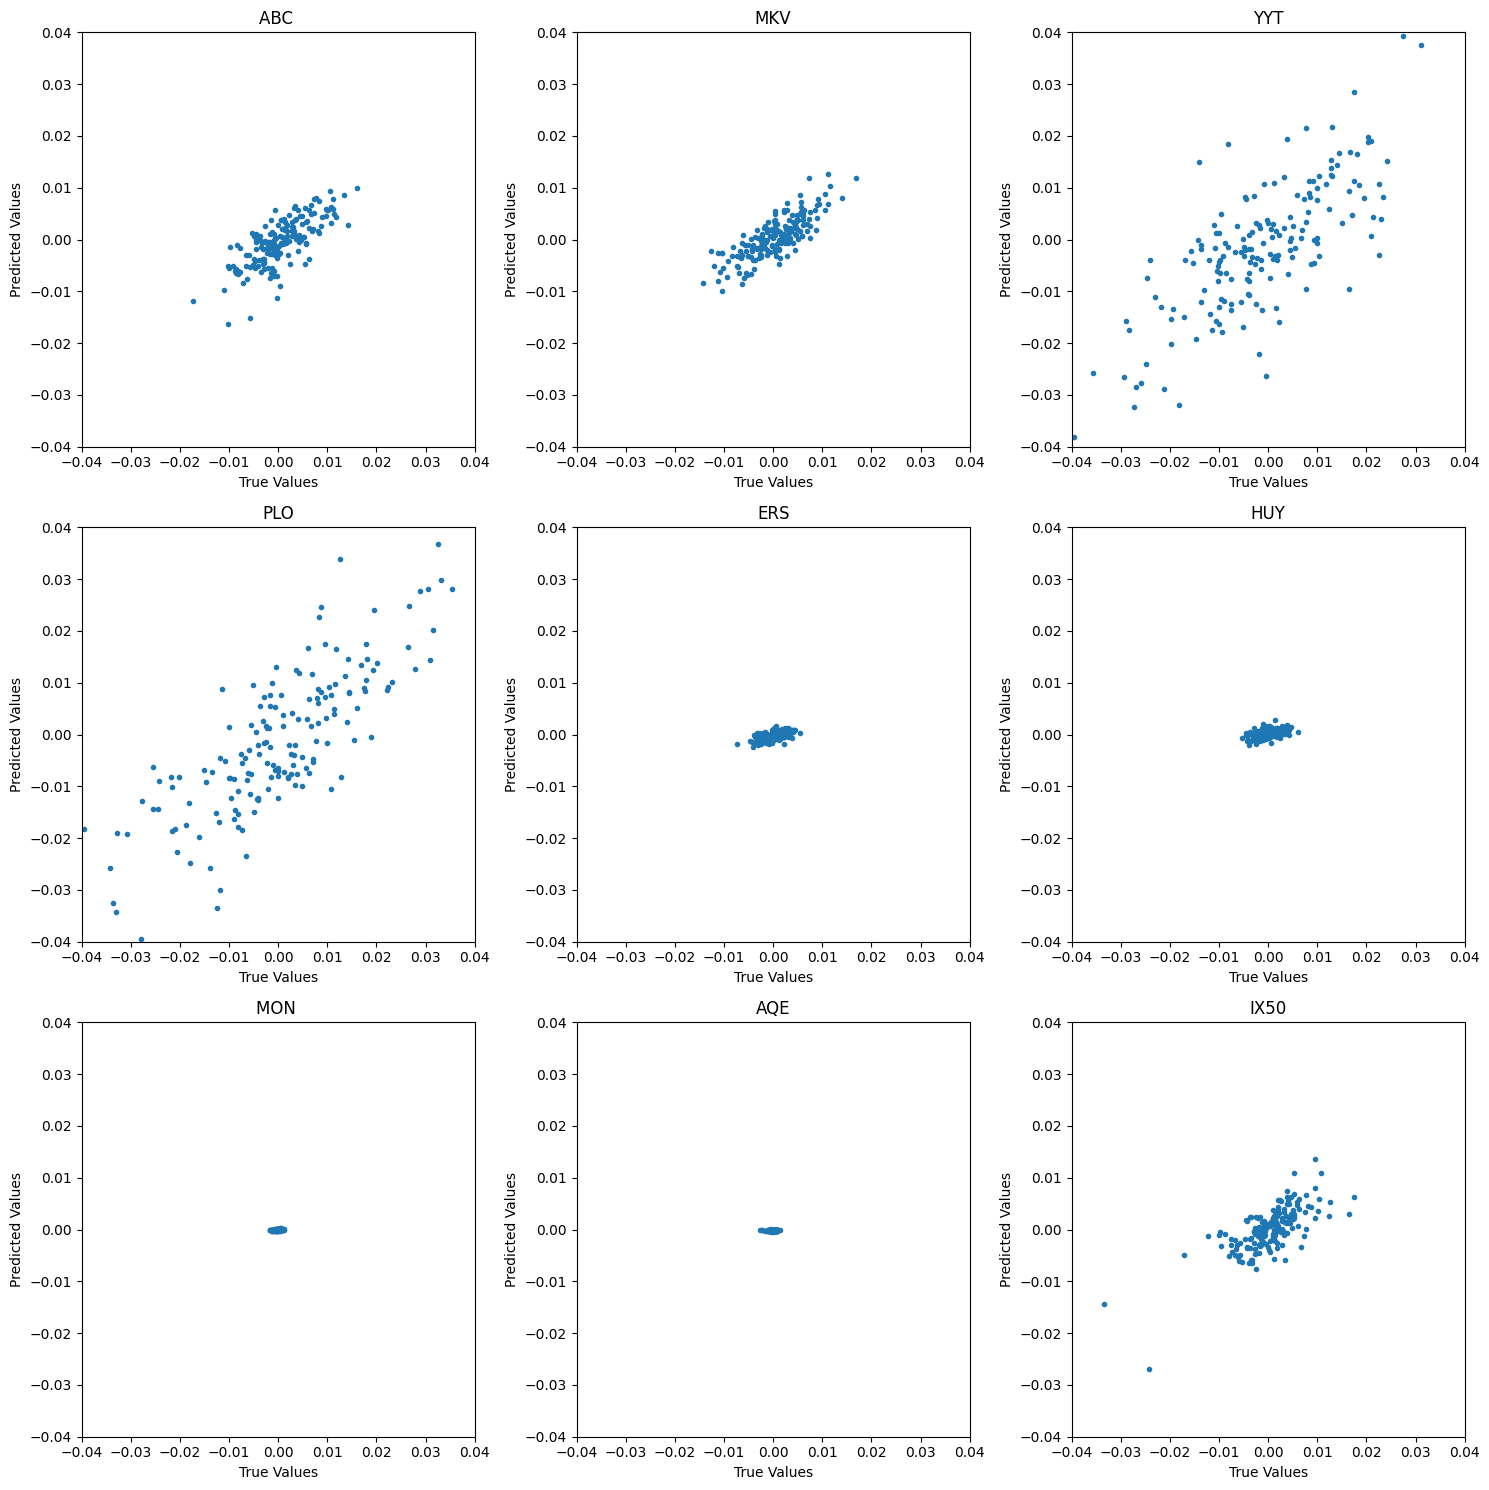

In [23]:
# Assuming y_test and y_pred are pandas DataFrames with the same columns and indices
fig, axes = plt.subplots(3, 3, figsize=(15, 15))  # Create a 3x3 grid of subplots
axes = axes.flatten()  # Flatten the 3x3 array of axes so we can iterate over it

for place, i in enumerate(y_test.columns):
    # Plot the true vs predicted values
    axes[place].plot(y_test[i], y_pred[i], '.') 
    axes[place].set_xlabel('True Values')
    axes[place].set_ylabel('Predicted Values')
    axes[place].set_ylim(-0.04,0.04)
    axes[place].set_xlim(-0.04,0.04)
    axes[place].set_title(f"{i}")
    
plt.tight_layout()  # Adjust subplots to fit in the figure area
plt.show()  # Display all subplots

## Trading Strategy Development 
This is an aggressive strategy. The idea is to predict the stock which has the highest return
<br>on any given day and invest fully into that stock. 
<br>Hence, the signal is the idmax of the predicted returns. 
<br>We see how the predicted returns, and the actual returns are derived from this strategy below.

In [24]:
# Create pct_change such that we find out where we predict best returns 
# We also add a "Zero" column. In the case of broad market downturns, we would ideally choose not to invest in any stocks

# For test set 
Predicted_returns = y_pred.copy()
Predicted_returns["Zero"] = 0 
Predicted_returns["Winner Return"] = Predicted_returns.max(axis=1)
Predicted_returns["Winner Name"] = Predicted_returns.idxmax(axis=1)

# For Validation Set 
Predicted_returns_val = y_val_pred.copy()
Predicted_returns_val["Zero"] = 0 
Predicted_returns_val["Winner Return"] = Predicted_returns_val.max(axis=1)
Predicted_returns_val["Winner Name"] = Predicted_returns_val.idxmax(axis=1)
Predicted_returns_val

,ABC,MKV,YYT,PLO,ERS,HUY,MON,AQE,IX50,Zero,Winner Return,Winner Name
0,-0.014576,-0.004311,-0.006651,0.009830,-0.000208,0.001154,-0.000137,-0.000161,0.001767,0,0.009830,PLO
1,-0.000012,-0.000015,-0.006212,0.007148,0.000059,-0.000094,0.000027,-0.000096,0.008922,0,0.008922,IX50
2,-0.005849,-0.002577,-0.000357,0.010176,0.000670,-0.000298,0.000046,-0.000064,0.005531,0,0.010176,PLO
3,0.001623,-0.001935,0.006392,0.011098,-0.001187,0.000326,-0.000050,-0.000209,-0.000412,0,0.011098,PLO
4,0.000835,-0.000686,-0.016342,0.000953,-0.001480,0.000438,-0.000153,-0.000144,0.009516,0,0.009516,IX50
...,...,...,...,...,...,...,...,...,...,...,...,...
97,0.002799,0.001523,0.002342,0.014478,0.000246,-0.000142,0.000057,-0.000114,0.009773,0,0.014478,PLO
98,0.002141,-0.001114,-0.000036,0.005398,-0.000861,0.000113,-0.000084,-0.000234,0.000318,0,0.005398,PLO
99,0.006342,-0.001526,0.005624,-0.016266,-0.000719,0.000375,-0.000055,-0.000103,0.000236,0,0.006342,ABC
100,-0.001166,-0.000707,0.028358,0.005053,-0.000873,0.000129,0.000022,-0.000335,-0.001541,0,0.028358,YYT


In [25]:
# Check out what the actual returns are 

# For test set 
Actual_returns = y_test.copy()
Actual_returns["Zero"] = 0 
Actual_returns["Winner Return"] = Actual_returns.max(axis=1)
Actual_returns["Winner Name"] = Actual_returns.idxmax(axis=1)
Actual_returns.reset_index(inplace=True, drop=True)

# For Validation Set 
Actual_returns_val = y_val.copy()
Actual_returns_val["Zero"] = 0 
Actual_returns_val["Winner Return"] = Actual_returns_val.max(axis=1)
Actual_returns_val["Winner Name"] = Actual_returns_val.idxmax(axis=1)
Actual_returns_val.reset_index(inplace=True, drop=True)
# Actual_returns_val

In [26]:
# Create a new DataFrame to store the results
df_results = pd.DataFrame(columns=['Time Period', 'Winner Name', 'Predicted Return', 'Actual Return'])

# Loop through each row in predicted. Create a df which shows the predicted returns (max of predictions) 
# and what the actual returns for that stock was 
for index, row in Predicted_returns.iterrows():
    winner_name = row['Winner Name']
    predicted_return = row[winner_name]
    actual_return = Actual_returns.loc[index, winner_name]
    df_results = df_results.append({
        'Time Period': index,
        'Winner Name': winner_name,
        'Predicted Return': predicted_return,
        'Actual Return': actual_return
    }, ignore_index=True)
df_results 

df_results_val = pd.DataFrame(columns=['Time Period', 'Winner Name', 'Predicted Return', 'Actual Return'])
for index, row in Predicted_returns_val.iterrows():
    winner_name_val = row['Winner Name']
    predicted_return_val = row[winner_name_val]
    actual_return_val = Actual_returns_val.loc[index, winner_name_val]
    df_results_val = df_results_val.append({
        'Time Period': index,
        'Winner Name': winner_name_val,
        'Predicted Return': predicted_return_val,
        'Actual Return': actual_return_val
    }, ignore_index=True)
df_results_val 

ptf_exp_returns = (df_results["Predicted Return"]+1).cumprod().iloc[-1]
ptf_exp_returns_val = (df_results_val["Predicted Return"]+1).cumprod().iloc[-1]


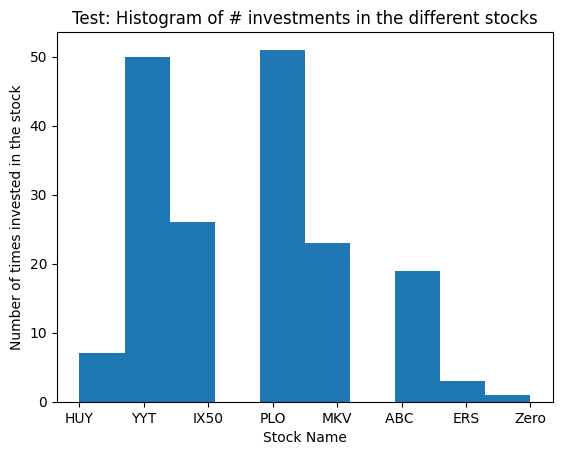

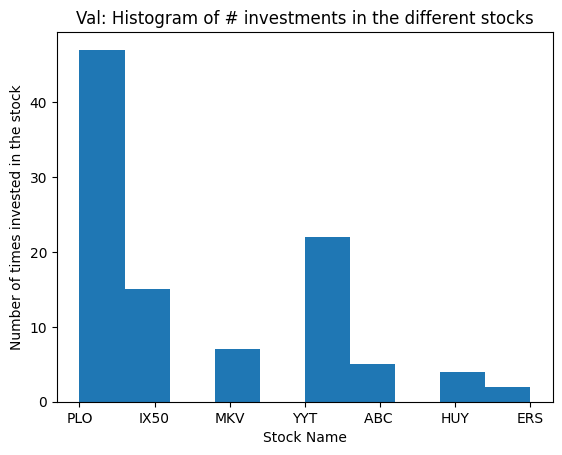

In [27]:
# For testing set 
plt.hist(df_results["Winner Name"])
plt.title("Test: Histogram of # investments in the different stocks")
plt.xlabel('Stock Name')
plt.ylabel('Number of times invested in the stock')
plt.show()

# For validation set 
plt.hist(df_results_val["Winner Name"])
plt.title("Val: Histogram of # investments in the different stocks")
plt.xlabel('Stock Name')
plt.ylabel('Number of times invested in the stock')
plt.show()

In [28]:
portfolio_cumulative_rets = (df_results["Actual Return"]+1).cumprod()
portfolio_cumulative_rets_val = (df_results_val["Actual Return"]+1).cumprod()
ptf_final_result = portfolio_cumulative_rets.iloc[-1]
ptf_final_result_val = portfolio_cumulative_rets_val.iloc[-1]


In [29]:
Initial_cash = 1_000_000

# Since we only can buy integer number of stocks, subtract 3000 
Cash = Initial_cash - 3000

nom_rets = pd.DataFrame(Cash * portfolio_cumulative_rets)

## Evaluation


### Final Returns

In [30]:
# Test set 
print("-"*13,"Test","-"*13)
# Perfect timing and stock picking. Aka. the highest possible return attainable 
Perfect_picking = (Actual_returns["Winner Return"]+1).cumprod().iloc[-1]
print(f"Perfect timing and stock picking had given this return: {(Perfect_picking-1)*100:.4f}%")

# A simple equal weight portfolio 
Equal_w_ptf_return = (Actual_returns[stock_columns].mean(axis=1)+1).cumprod().iloc[-1]
print(f"An equally weighted portfolio had given a return of: {(Equal_w_ptf_return-1)*100:.4f}%" )

# My Portfolio 
print(f"Our portfolios expected return is: {(ptf_exp_returns-1)*100:.4f}%")
print(f"Our portfolio has returned a return of: {(ptf_final_result-1)*100:.4f}%")


# Validation set 
print("-"*10,"Validation","-"*10)
# Perfect timing and stock picking. Aka. the highest possible return attainable 
Perfect_picking_val = (Actual_returns_val["Winner Return"]+1).cumprod().iloc[-1]
print(f"Perfect timing and stock picking had given this return: {(Perfect_picking_val-1)*100:.4f}%")

# A simple equal weight portfolio 
Equal_w_ptf_return_val = (Actual_returns_val[stock_columns].mean(axis=1)+1).cumprod().iloc[-1]
print(f"An equally weighted portfolio had given a return of: {(Equal_w_ptf_return_val-1)*100:.4f}%" )

# My Portfolio 
print(f"Our portfolios expected return is: {(ptf_exp_returns_val-1)*100:.4f}%")
print(f"Our portfolio has returned a return of: {(ptf_final_result_val-1)*100:.4f}%")

------------- Test -------------
Perfect timing and stock picking had given this return: 1074.1989%
An equally weighted portfolio had given a return of: 3.4257%
Our portfolios expected return is: 583.4766%
Our portfolio has returned a return of: 607.7248%
---------- Validation ----------
Perfect timing and stock picking had given this return: 353.6735%
An equally weighted portfolio had given a return of: 1.7584%
Our portfolios expected return is: 257.8424%
Our portfolio has returned a return of: 256.3963%


### Annualized Returns

In [31]:
# Test set 
print("-"*13,"Test","-"*13)

# Equal weight portfolio 
eq_w_annualized = ((Equal_w_ptf_return**2)-1)*100
print(f"The equal weight portfolio gives annualized returns of: {eq_w_annualized:.4f}%")

# My Portfolio 
my_ptf_annualized = ((ptf_final_result**2)-1)*100
print(f"My portfolio gives annualized returns of: {my_ptf_annualized:.4f}%\n")

# Validation set 
print("-"*10,"Validation","-"*10)

# Equal weight portfolio 
eq_w_annualized_val = ((Equal_w_ptf_return_val**2)-1)*100
print(f"The equal weight portfolio gives annualized returns of: {eq_w_annualized_val:.4f}%")

# My Portfolio 
my_ptf_annualized_val = ((ptf_final_result_val**2)-1)*100
print(f"My portfolio gives annualized returns of: {my_ptf_annualized_val:.4f}%")

------------- Test -------------
The equal weight portfolio gives annualized returns of: 6.9687%
My portfolio gives annualized returns of: 4908.7435%

---------- Validation ----------
The equal weight portfolio gives annualized returns of: 3.5477%
My portfolio gives annualized returns of: 1170.1835%


### Annual Sharpe Ratio

In [32]:
# Testing set 
print("-"*13,"Test","-"*13)

# Equal Weighted 
eq_w_rets_std = (y_test.mean(axis=1)).std()*np.sqrt(2)
eq_w_sharpe = (eq_w_annualized/100) / (eq_w_rets_std)
print(f"Equal Weight Portfolio Returns: {eq_w_annualized:.4f}%")
print(f"Equal Weight Portfolio Standard Deviation: {eq_w_rets_std:.4f}")
print(f"Equal Weight Portfolio Sharpe Ratio: {eq_w_sharpe:.4f}")

print("-"*40)
# My Portfolio
my_ptf_rets_std = portfolio_cumulative_rets.std()*np.sqrt(2)
my_ptf_sharpe = (my_ptf_annualized/100)/(my_ptf_rets_std)
print(f"Portfolio Return: {my_ptf_annualized:.4f}%")
print(f"Portfolio Standard Deviation: {my_ptf_rets_std:.4f}")
print(f"Portfolio Sharpe Ratio: {my_ptf_sharpe:.4f}\n")


# Validation set 
print("-"*10,"Validation","-"*10)


# Equal Weighted 
eq_w_rets_std_val = (y_val.mean(axis=1)).std()*np.sqrt(2)
eq_w_sharpe_val = (eq_w_annualized_val/100) / (eq_w_rets_std_val)
print(f"Equal Weight Portfolio Returns: {eq_w_annualized_val:.4f}%")
print(f"Equal Weight Portfolio Standard Deviation: {eq_w_rets_std_val:.4f}")
print(f"Equal Weight Portfolio Sharpe Ratio: {eq_w_sharpe_val:.4f}")

print("-"*40)
# My Portfolio
my_ptf_rets_std_val = portfolio_cumulative_rets_val.std()*np.sqrt(2)
my_ptf_sharpe_val = (my_ptf_annualized_val/100)/(my_ptf_rets_std_val)
print(f"Portfolio Return: {my_ptf_annualized_val:.4f}%")
print(f"Portfolio Standard Deviation: {my_ptf_rets_std_val:.4f}")
print(f"Portfolio Sharpe Ratio: {my_ptf_sharpe_val:.4f}")

------------- Test -------------
Equal Weight Portfolio Returns: 6.9687%
Equal Weight Portfolio Standard Deviation: 0.0046
Equal Weight Portfolio Sharpe Ratio: 15.1306
----------------------------------------
Portfolio Return: 4908.7435%
Portfolio Standard Deviation: 2.3413
Portfolio Sharpe Ratio: 20.9658

---------- Validation ----------
Equal Weight Portfolio Returns: 3.5477%
Equal Weight Portfolio Standard Deviation: 0.0044
Equal Weight Portfolio Sharpe Ratio: 7.9995
----------------------------------------
Portfolio Return: 1170.1835%
Portfolio Standard Deviation: 1.0290
Portfolio Sharpe Ratio: 11.3720


### Maximum Drawdown on 6 months

In [33]:
def maximum_drawdown(cumulative_rets):
    # Calculate the drawdown at each time point
    drawdown = 1 - cumulative_rets.div(cumulative_rets.cummax())
    
    # Find the maximum drawdown
    mdd = drawdown.max()

    return mdd

# Testing set 
print("-"*13,"Test","-"*13)

mdd_portfolio = maximum_drawdown(portfolio_cumulative_rets)
mdd_eq_weight_ptf = maximum_drawdown((Actual_returns[stock_columns].mean(axis=1)+1).cumprod()) 
print(f"The Maximum Drawdown of our portfolio is: {-mdd_portfolio*100:.4f}%")
print(f"The Maximum Drawdown of the equal weight portfolio is: {-mdd_eq_weight_ptf*100:.4f}%\n")


# Validation set 
print("-"*10,"Validation","-"*10)

mdd_portfolio_val = maximum_drawdown(portfolio_cumulative_rets_val)
mdd_eq_weight_ptf_val = maximum_drawdown((Actual_returns_val[stock_columns].mean(axis=1)+1).cumprod()) 
print(f"The Maximum Drawdown of our portfolio is: {-mdd_portfolio_val*100:.4f}%")
print(f"The Maximum Drawdown of the equal weight portfolio is: {-mdd_eq_weight_ptf_val*100:.4f}%")

------------- Test -------------
The Maximum Drawdown of our portfolio is: -2.2272%
The Maximum Drawdown of the equal weight portfolio is: -3.2539%

---------- Validation ----------
The Maximum Drawdown of our portfolio is: -0.8676%
The Maximum Drawdown of the equal weight portfolio is: -4.2638%


### Cumulative Return

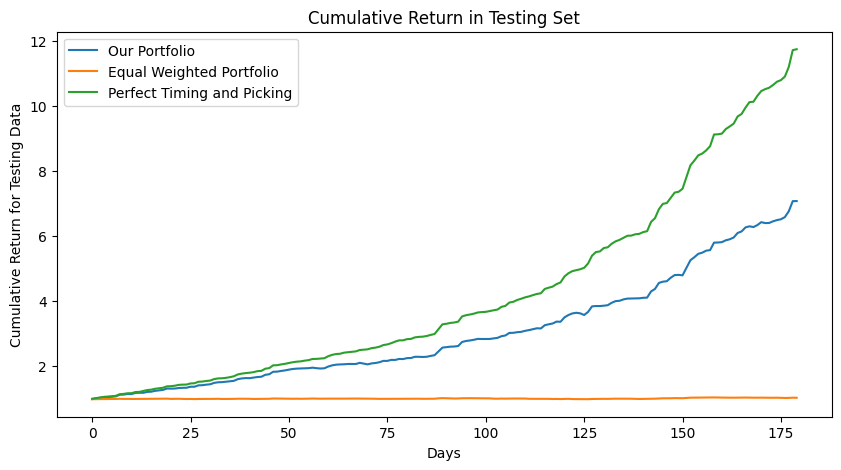

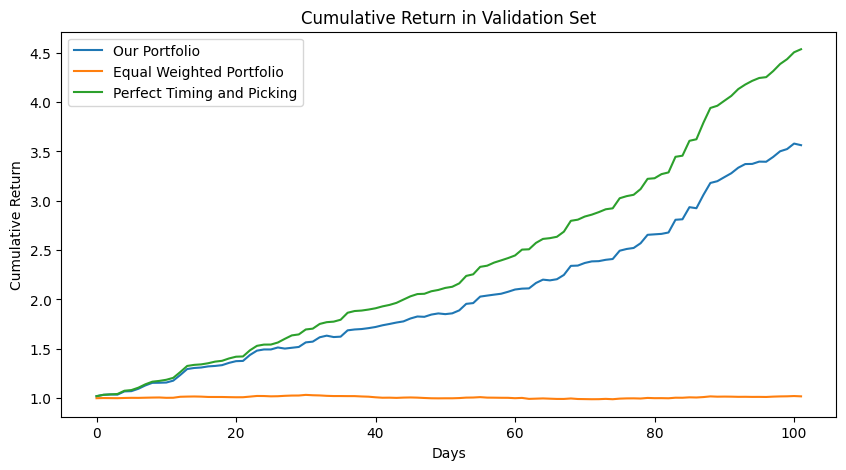

In [34]:
# Testing 
plt.figure(figsize=(10,5))
plt.plot(portfolio_cumulative_rets, label="Our Portfolio")
plt.plot((Actual_returns[stock_columns].mean(axis=1)+1).cumprod(), label="Equal Weighted Portfolio")
plt.plot((Actual_returns["Winner Return"]+1).cumprod(), label="Perfect Timing and Picking")
plt.xlabel("Days")
plt.ylabel("Cumulative Return for Testing Data")
plt.legend(loc="upper left")
plt.title("Cumulative Return in Testing Set")
plt.show()

# Validation 
plt.figure(figsize=(10,5))
plt.plot(portfolio_cumulative_rets_val, label="Our Portfolio")
plt.plot((Actual_returns_val[stock_columns].mean(axis=1)+1).cumprod(), label="Equal Weighted Portfolio")
plt.plot((Actual_returns_val["Winner Return"]+1).cumprod(), label="Perfect Timing and Picking")
plt.xlabel("Days")
plt.ylabel("Cumulative Return")
plt.legend(loc="upper left")
plt.title("Cumulative Return in Validation Set")
plt.show()

### Correlation of My Portfolio with the Equally Weighted Market Portfolio

The correlation with the Equal Weight Portfolio is: 0.7906
The correlation with the Perfect Picking Portfolio is: 0.9980


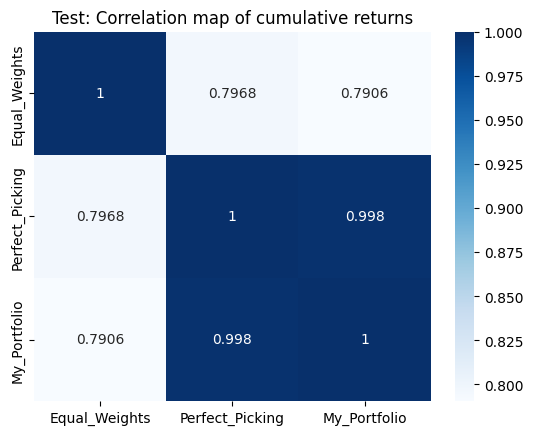

The correlation with the Equal Weight Portfolio is: -0.0419
The correlation with the Perfect Picking Portfolio is: 0.9996


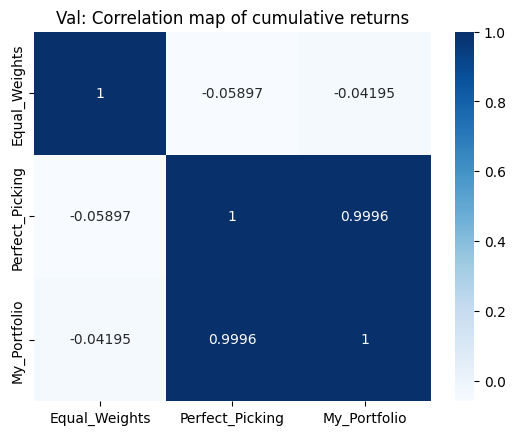

In [35]:
# Test set 
correlation_eq_myptf = np.corrcoef((y_test.mean(axis=1)+1).cumprod(),portfolio_cumulative_rets)
print(f"The correlation with the Equal Weight Portfolio is: {correlation_eq_myptf[1,0]:.4f}")

correlation_perf_myptf = np.corrcoef((Actual_returns["Winner Return"]+1).cumprod(),portfolio_cumulative_rets)
print(f"The correlation with the Perfect Picking Portfolio is: {correlation_perf_myptf[1,0]:.4f}")

all_results = pd.DataFrame([(y_test.mean(axis=1)+1).cumprod().reset_index(level=None,drop=True),(Actual_returns["Winner Return"]+1).cumprod(),portfolio_cumulative_rets]).T
all_results.columns = ["Equal_Weights","Perfect_Picking","My_Portfolio"]

corr = all_results.corr()
sns.heatmap(corr, cmap="Blues", annot=True,fmt=".4g")
plt.title(label="Test: Correlation map of cumulative returns")
plt.show()
# display(all_results)

# Validation set  
correlation_eq_myptf_val = np.corrcoef((y_val.mean(axis=1)+1).cumprod(),portfolio_cumulative_rets_val)
print(f"The correlation with the Equal Weight Portfolio is: {correlation_eq_myptf_val[1,0]:.4f}")

correlation_perf_myptf_val = np.corrcoef((Actual_returns_val["Winner Return"]+1).cumprod(),portfolio_cumulative_rets_val)
print(f"The correlation with the Perfect Picking Portfolio is: {correlation_perf_myptf_val[1,0]:.4f}")

all_results_val = pd.DataFrame([(y_val.mean(axis=1)+1).cumprod().reset_index(level=None,drop=True),(Actual_returns_val["Winner Return"]+1).cumprod(),portfolio_cumulative_rets_val]).T
all_results_val.columns = ["Equal_Weights","Perfect_Picking","My_Portfolio"]

corr_val = all_results_val.corr()
sns.heatmap(corr_val, cmap="Blues", annot=True,fmt=".4g")
plt.title(label="Val: Correlation map of cumulative returns")
plt.show()
# display(all_results_val)
